## Pairs Of Adjacent Duplicates

Now that we have the first problem mostly working, let's try another.


Given a sequence of numbers, find and mark adjacent duplicates. For simplicity, we'll only have one duplicate in each input.

```
input  = 0 3 5 9 3 3 5 2 5
output = 0 0 0 0 1 1 0 0 0
```


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from radam import RAdam
from transformers import BertConfig, BertModel
from torch.utils.data import DataLoader, Dataset
from utils import train, get_accuracy, get_output_for_example, plot_losses

In [2]:
def generate_data(num_examples: int, seq_len: int, vocab_size: int):
    inputs = np.random.randint(0, vocab_size, size=(num_examples, seq_len))
    outputs = np.zeros_like(inputs)
    
    for i in range(len(inputs)):
        
        # choose number of duplicates to introduce
        num_duplicates = 2
        
        # choose random location to introduce our duplicates
        location = np.random.randint(0, len(inputs[i]) - num_duplicates)
        
        # Choose what number we'd like to repeat
        number_to_repeat = np.random.randint(0, vocab_size)
        
        inputs[i][location:location + num_duplicates] = number_to_repeat
        
        # Mark location where duplicates exist
        outputs[i][location:location + num_duplicates] = 1
        

    return inputs, outputs

In [3]:
# We're lazy so we're going to just use a large vocabulary 
# instead of manually removing accidental duplicates
generate_data(num_examples=1, seq_len=10, vocab_size=1000)

(array([[286, 297, 872, 172, 968, 968, 879, 771, 780, 809]]),
 array([[0, 0, 0, 0, 1, 1, 0, 0, 0, 0]]))

In [4]:
class ToyDataset(Dataset):
   
    def __init__(self, num_examples, sequence_length, vocab_size):
        self.items, self.labels = generate_data(num_examples, sequence_length, vocab_size)
        
    def __getitem__(self, idx):
        
        x = torch.Tensor(self.items[idx]).long()
        y = torch.Tensor(self.labels[idx]).long()
        return x.cuda(), y.cuda()
    
    def __len__(self):
        return len(self.items)

In [5]:
class ToyModel(torch.nn.Module):
    """
    Wrapper around a BERT model that predicts a single binary output for each input token
    """
    
    def __init__(self, vocab_size):
        super().__init__()
        
        # Untrained BERT Model
        config = BertConfig(vocab_size_or_config_json_file=vocab_size)
        self.bert_model = BertModel(config)
        self.linear = torch.nn.Linear(in_features=768, out_features=2)
        
    def forward(self, x):    
        out, _ = self.bert_model(x)
        out = self.linear(out)
        return out    

In [22]:
TRN_EXAMPLES = 128
VAL_EXAMPLES = 120
SEQ_LENGTH = 10
VOCAB_SIZE = 1000
BATCH_SIZE = 32
LR = 1e-4

train_ds = ToyDataset(num_examples=TRN_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
valid_ds = ToyDataset(num_examples=VAL_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [23]:
model = ToyModel(VOCAB_SIZE)
model = model.cuda()

In [24]:
# NOTE: We use RAdam to avoid having to use warmup
# If we use regular Adam, this usually won't converge for long sequences
optimizer = RAdam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()

In [25]:
trn_loss, val_loss, val_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs=50, print_every=100)

Epoch:	 0 	Step:	 0 	Loss:	 0.549916684627533
Epoch:	 0 			Valid Accuracy	 0.79348963
Epoch:	 1 	Step:	 0 	Loss:	 0.5504586100578308
Epoch:	 1 			Valid Accuracy	 0.8000001
Epoch:	 2 	Step:	 0 	Loss:	 0.5850911140441895
Epoch:	 2 			Valid Accuracy	 0.7893229
Epoch:	 3 	Step:	 0 	Loss:	 0.49532175064086914
Epoch:	 3 			Valid Accuracy	 0.79453135
Epoch:	 4 	Step:	 0 	Loss:	 0.46877628564834595
Epoch:	 4 			Valid Accuracy	 0.7984375
Epoch:	 5 	Step:	 0 	Loss:	 0.4457995295524597
Epoch:	 5 			Valid Accuracy	 0.76744795
Epoch:	 6 	Step:	 0 	Loss:	 0.4453398585319519
Epoch:	 6 			Valid Accuracy	 0.7963542
Epoch:	 7 	Step:	 0 	Loss:	 0.4241681694984436
Epoch:	 7 			Valid Accuracy	 0.7757813
Epoch:	 8 	Step:	 0 	Loss:	 0.4092821180820465
Epoch:	 8 			Valid Accuracy	 0.7945312
Epoch:	 9 	Step:	 0 	Loss:	 0.39121687412261963
Epoch:	 9 			Valid Accuracy	 0.7710938
Epoch:	 10 	Step:	 0 	Loss:	 0.3617556095123291
Epoch:	 10 			Valid Accuracy	 0.7861979
Epoch:	 11 	Step:	 0 	Loss:	 0.3348979949951172

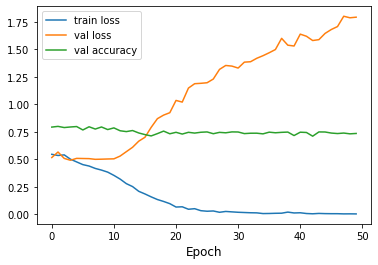

In [26]:
plot_losses(trn_loss, val_loss, val_acc)

Although we're getting low training loss, we've clearly overfit our dataset as validation loss has exploded. Additionally we're getting about 80% validation accuracy at best which is as much as we could expect when predicting all `0`. (80% of each example is `0`).

Let's try adding ten times as much training data.

In [34]:
# Ten times as much data as before
TRN_EXAMPLES = 1280
VAL_EXAMPLES = 1200
# Other parameters are kept the same
SEQ_LENGTH = 10
VOCAB_SIZE = 1000
BATCH_SIZE = 32
LR = 1e-4

train_ds = ToyDataset(num_examples=TRN_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
valid_ds = ToyDataset(num_examples=VAL_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [35]:
model = ToyModel(VOCAB_SIZE)
model = model.cuda()

In [36]:
# NOTE: We use RAdam to avoid having to use warmup
# If we use regular Adam, this usually won't converge for long sequences
optimizer = RAdam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()

In [37]:
trn_loss, val_loss, val_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs=50, print_every=100)

Epoch:	 0 	Step:	 0 	Loss:	 0.6584423184394836
Epoch:	 0 			Valid Accuracy	 0.7999999
Epoch:	 1 	Step:	 0 	Loss:	 0.47321218252182007
Epoch:	 1 			Valid Accuracy	 0.799671
Epoch:	 2 	Step:	 0 	Loss:	 0.46234917640686035
Epoch:	 2 			Valid Accuracy	 0.79654604
Epoch:	 3 	Step:	 0 	Loss:	 0.4707900583744049
Epoch:	 3 			Valid Accuracy	 0.7849507
Epoch:	 4 	Step:	 0 	Loss:	 0.46136125922203064
Epoch:	 4 			Valid Accuracy	 0.7602796
Epoch:	 5 	Step:	 0 	Loss:	 0.4570659101009369
Epoch:	 5 			Valid Accuracy	 0.7592928
Epoch:	 6 	Step:	 0 	Loss:	 0.4252626895904541
Epoch:	 6 			Valid Accuracy	 0.7473685
Epoch:	 7 	Step:	 0 	Loss:	 0.3852044939994812
Epoch:	 7 			Valid Accuracy	 0.71422696
Epoch:	 8 	Step:	 0 	Loss:	 0.3179878294467926
Epoch:	 8 			Valid Accuracy	 0.7283717
Epoch:	 9 	Step:	 0 	Loss:	 0.3127977252006531
Epoch:	 9 			Valid Accuracy	 0.7277138
Epoch:	 10 	Step:	 0 	Loss:	 0.27355897426605225
Epoch:	 10 			Valid Accuracy	 0.7144737
Epoch:	 11 	Step:	 0 	Loss:	 0.3094567060470581

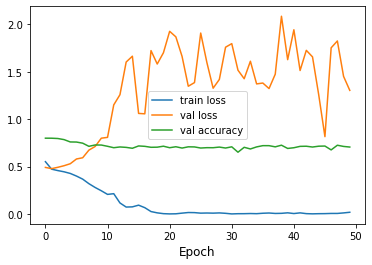

In [38]:
plot_losses(trn_loss, val_loss, val_acc)

We're still getting low training loss, but high validation loss and poor validation accuracy.

Let's try adding more data!

In [39]:
# 100x as much data as before
TRN_EXAMPLES = 12800
VAL_EXAMPLES = 1200
# Other parameters are kept the same
SEQ_LENGTH = 10
VOCAB_SIZE = 1000
BATCH_SIZE = 32
LR = 1e-4

train_ds = ToyDataset(num_examples=TRN_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
valid_ds = ToyDataset(num_examples=VAL_EXAMPLES, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [40]:
model = ToyModel(VOCAB_SIZE)
model = model.cuda()

In [41]:
# NOTE: We use RAdam to avoid having to use warmup
# If we use regular Adam, this usually won't converge for long sequences
optimizer = RAdam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()

In [42]:
trn_loss, val_loss, val_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs=10, print_every=100)

Epoch:	 0 	Step:	 0 	Loss:	 0.844509482383728
Epoch:	 0 	Step:	 100 	Loss:	 0.4921850264072418
Epoch:	 0 	Step:	 200 	Loss:	 0.4671918749809265
Epoch:	 0 	Step:	 300 	Loss:	 0.4769051969051361
Epoch:	 0 			Valid Accuracy	 0.7999999
Epoch:	 1 	Step:	 0 	Loss:	 0.47771650552749634
Epoch:	 1 	Step:	 100 	Loss:	 0.481773316860199
Epoch:	 1 	Step:	 200 	Loss:	 0.45999717712402344
Epoch:	 1 	Step:	 300 	Loss:	 0.46936410665512085
Epoch:	 1 			Valid Accuracy	 0.7999999
Epoch:	 2 	Step:	 0 	Loss:	 0.48127609491348267
Epoch:	 2 	Step:	 100 	Loss:	 0.4805912375450134
Epoch:	 2 	Step:	 200 	Loss:	 0.45702213048934937
Epoch:	 2 	Step:	 300 	Loss:	 0.4726109504699707
Epoch:	 2 			Valid Accuracy	 0.7999999
Epoch:	 3 	Step:	 0 	Loss:	 0.4735395908355713
Epoch:	 3 	Step:	 100 	Loss:	 0.4819353520870209
Epoch:	 3 	Step:	 200 	Loss:	 0.442431777715683
Epoch:	 3 	Step:	 300 	Loss:	 0.47053855657577515
Epoch:	 3 			Valid Accuracy	 0.7999999
Epoch:	 4 	Step:	 0 	Loss:	 0.4508120119571686
Epoch:	 4 	Step:	 

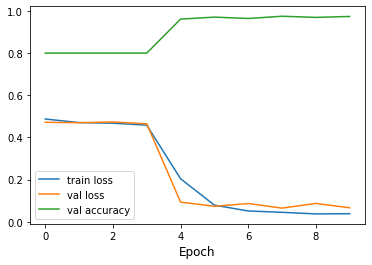

In [43]:
plot_losses(trn_loss, val_loss, val_acc)

So it looks like we need much more data in order to get our network to learn the solution. It also never quite reaches 100% accuracy. Perhaps lowering the learning rate would have helped at the end? 

Most of the learning seems to have happened between epochs 3 and 4.